# **Implementing a Quantum-Classical Parameter Mapping**
# **NO TESTS OR EXPLANATIONS**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import math
import re
from numba import njit
from itertools import product
from scipy.linalg import kron
from typing import Tuple, Optional, Dict, List
from numba.typed import List

## **Obtaining a valid transition matrix**

In [2]:
###  CONVERTING SPIN <-> BINARY FUNCTIONS
#----------------------------------------------------------------------
@njit
def index_to_spin_state(s_idx: int, N: int) -> np.ndarray:
    """Convert an index to a spin state."""
    s = np.zeros((N,), dtype=np.int64)
    for i in range(N):
        # get the ith bit of s_idx.
        bit = (s_idx >> i) & 1
        # convert the bit to a spin (-1 or 1).
        s[N - 1 - i] = bit * 2 - 1
    return s

@njit
def spin_state_to_index(s: np.ndarray) -> int:
    """Convert a spin state to an index."""
    N = len(s)
    s_idx = 0
    for i in range(N):
        # convert the spin to a bit (0 or 1).
        bit = (s[i] + 1) // 2
        # set the ith bit of s_idx.
        s_idx |= bit << (N - 1 - i)
    return s_idx

@njit
def bits_flipped_indices(s_idx: int, flip_index: int, N: int) -> List[int]:
    """Return the indices of the bits that are flipped when going from s_idx to flip_index."""
    flipped_bits = s_idx ^ flip_index
    flipped_indices = []
    for k in range(N):
        if (flipped_bits & (1 << k)) != 0:
            flipped_indices.append(N - 1 - k)
    return flipped_indices

@njit
def steady_state(A):
    """Calculates the steady state of a (left) stochastic matrix"""
    # compute eigenvalues and corresponding eigenvectors for the transposed matrix
    eigenvalues, eigenvectors = np.linalg.eig(A.T)
    
    # get the eigenvector corresponding to eigenvalue 1 (the steady state)
    steady_state = np.abs(np.real(eigenvectors[:, np.argmax(np.real(eigenvalues))]))
    
    # normalize the vector to get a probability distribution
    steady_state = steady_state / np.sum(steady_state)
    
    return steady_state.flatten()

In [3]:
### AUXILARY SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def g_single(i: int, s: np.ndarray, w: np.ndarray, h: np.ndarray, J: np.ndarray):
    """Calculates the single flip probability."""
    sum_Js = np.sum(J[i, :] * s)
    return np.exp(-w[i, i] - s[i] * (h[i] + sum_Js))

@njit
def g_double(i: int, j: int, s: np.ndarray, w: np.ndarray, h: np.ndarray, J: np.ndarray):
    """Calculates the double flip probability"""
    sum_Js_i = np.sum(J[i, :] * s) - J[i, j] * s[j]
    sum_Js_j = np.sum(J[j, :] * s) - J[i, j] * s[i]

    return np.exp(-w[i, j] + J[i, j] * s[i] * s[j] - s[i] * (sum_Js_i + h[i]) - s[j] * (sum_Js_j + h[j]))

@njit
def choice(probabilities: np.ndarray) -> int:
    """A workaround for np.random.choice, which is unsupported by numba"""
    cumulative_distribution = np.cumsum(probabilities)
    return np.searchsorted(cumulative_distribution, np.random.random(), side ="right")

In [4]:
@njit
def compute_transition_matrix(w: np.ndarray, h: np.ndarray, J: np.ndarray) -> np.ndarray:
    """Computes the transition matrix for the given parameters."""
    N = len(h)  # number of spins in the lattice
    transition_matrix = np.zeros((2**N, 2**N))

    #sum over rows to fill
    for s_idx in range(2**N):
        s = index_to_spin_state(s_idx, N)
        flip_probs = np.zeros((2**N))  # initialize with zeros

        for i in range(N):
            flip_index = s_idx ^ (1 << i)
            i_flipped = bits_flipped_indices(s_idx, flip_index, N)[0]
            flip_probs[flip_index] = g_single(i_flipped, s, w, h, J)  # single flip probabilities

        for i in range(N):
            for j in range(i+1, N):
                flip_index = s_idx ^ (1 << i) ^ (1 << j)
                i_flipped, j_flipped = bits_flipped_indices(s_idx, flip_index, N)
                flip_probs[flip_index] = g_double(i_flipped, j_flipped, s, w, h, J)  # double flip probabilities

       # add the no-flip probability and store the flipping probabilities
        no_flip_prob = 1 - sum(flip_probs)
        flip_probs[s_idx] = no_flip_prob
        transition_matrix[s_idx] = flip_probs

    return transition_matrix

In [5]:
def check_w(w, h, J, step_size = 1e-4, no_flip_prob = 0):
    """Checks if w gives rise to a proper normalized W. Prints the minimal value of w required if it's not the case"""
    min_scalar = 0
    W = compute_transition_matrix(w, h, J)
    self_probs = np.diag(W.copy())

    if np.all(self_probs >= no_flip_prob):
        return
    else:
        self_probs_old = self_probs.copy()
        while True:
            new_w             = w + np.ones(w.shape) * min_scalar
            W = compute_transition_matrix(new_w, h, J)
            self_probs        = np.diag(W)

            # check if the self-transition probabilities are all at least no_flip_prob
            if np.all(self_probs >= no_flip_prob):
                break

            # if the condition is not met, increase the scalar value and try again
            min_scalar += step_size

        assert np.all(self_probs_old >= no_flip_prob), f"Need to use larger w matrix: \n {new_w} "

def check_parameters(w, J, h):
    """Check if parameters are chosen to give rise to a normalized W that satisfies detailed balance"""
    check_w(w, h, J)
    assert np.allclose(J, J.T) and np.allclose(w, w.T) and np.all(J.diagonal() == 0),  "Input matrices w and J should be symmetric and J should have a zero diagonal"


def check_detailed_balance(W):
    """
    Check if the transition matrix W and stationary distribution pi satisfy the detailed balance condition.
    """
    pi = steady_state(W)
    n_states = W.shape[0]
    for i in range(n_states):
        for j in range(n_states):
            assert np.isclose(W[i, j] * pi[i], W[j, i] * pi[j]), "Transition matrix does not satisfy detailed balance"


def test_transition_matrix(W):
    """Test that the sum of the probabilities in each row of the transition matrix is 1 and there are no negative elements."""
    for row in W:
        assert np.isclose(np.sum(row), 1), "Row sums to " + str(np.sum(row))
        assert np.all(row >= 0), "Negative probability in row " + str(row)

In [6]:
###  SIMULATION FUNCTIONS
#----------------------------------------------------------------------
@njit
def spin_flip(s: np.ndarray, transition_matrix: np.ndarray) -> np.ndarray:
    """ Flipping algorithm, uses precomputed transition matrix. """
    N = len(s)  # number of spins in the lattice

    # calculate the index of the current state in the transition matrix
    s_idx = spin_state_to_index(s)

    # get probabilities from transition matrix
    flip_probs = transition_matrix[s_idx]

    # randomly choose a spin flip according to its probability of occurring
    idx = choice(flip_probs)

    # apply the chosen spin flip
    flipped_indices = bits_flipped_indices(s_idx, idx, N)
    
    if len(flipped_indices)   == 0:  # no flip
        pass
    elif len(flipped_indices) == 1:  # single flip
        i = flipped_indices[0]
        s[i] *= -1
    elif len(flipped_indices) == 2:  # double flip
        i, j = flipped_indices
        s[i] *= -1
        s[j] *= -1

    return s

@njit
def simulate_dynamics(W: np.ndarray, steps: int, N: int) -> np.ndarray:
    """Simulates the dynamics of the system for the given number of steps."""
    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(N)], dtype=np.int64) #initial config
    trajectory = np.empty((steps, N), dtype=np.int64)

    for t in range(steps):
        s = spin_flip(s, W)
        trajectory[t] = s

    return trajectory

In [7]:
@njit
def infer_transition_matrix(trajectory: np.ndarray) -> np.ndarray:
    """Infers the transition matrix from a time series of the states of the system"""
    N = trajectory.shape[1]  # number of spins in the lattice
    steps = trajectory.shape[0]  # number of steps in the trajectory
    transition_matrix = np.zeros((2**N, 2**N))

    for t in range(steps - 1):
        # convert the spin states to indices
        s_idx = spin_state_to_index(trajectory[t])
        next_s_idx = spin_state_to_index(trajectory[t + 1])

        # increment the corresponding cell in the transition matrix
        transition_matrix[s_idx, next_s_idx] += 1

    # normalize each row to get probabilities
    for i in range(2**N):
        row_sum = np.sum(transition_matrix[i])
        if row_sum > 0:  # avoid division by zero
            transition_matrix[i] /= row_sum

    return transition_matrix

In [8]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_combined_dynamics(trajectory, N):
    fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the system's evolution through states
    states = [(''.join(['0' if spin == -1 else '1' for spin in s])) for s in trajectory]  # convert spins to binary
    unique_states = sorted(set(states))
    state_indices = [unique_states.index(state) for state in states]
    
    ax1.step(range(len(state_indices)), state_indices)
    ax1.set_yticks(range(len(unique_states)))
    ax1.set_yticklabels(unique_states)
    ax1.set_title("System's evolution through states")
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('State')

    # Plot for the spins' evolution
    offset_labels = []
    y_ticks = []
    for i in range(N):
        spin_trajectory = trajectory[:, i] + i * 3
        ax2.step(range(len(spin_trajectory)), spin_trajectory, label=f'Spin {i+1}')
        offset_labels += ['0', '1']
        y_ticks += [(i*3 - 1), (i*3 +1)]
        
    ax2.set_title("Spins' evolution")
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Spin value (with offset)')
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels(offset_labels)
    ax2.legend(loc='best')
    ax2.plot()
    
    plt.tight_layout()
    plt.show()

## **Implementation of the Boltzmann Machine**

In [9]:
###  BOLTZMANN MACHINE AUXILARY FUNCTIONS
#----------------------------------------------------------------------
def all_possible_configs(N: int) -> np.ndarray:
    '''Generates a 2^N by N matrix with all possible configurations of a binary spin system of size N'''
    configs = np.zeros((2**N,N))
    for i in range(2**N):
        config = np.array([1 if x == '1' else -1 for x in np.binary_repr(i, width=N)])
        configs[i] = config
    return configs

@njit
def calcEnergy(config: np.ndarray, J: np.ndarray, h: np.ndarray) -> float:
    '''Calculates the energy of a given configuration'''
    config_float = config.astype(np.float64)  # convert config to float
    energy = -np.dot(config_float.T, np.dot(J, config_float)) / 2 - np.dot(h, config_float)
    return energy

@njit
def calcMag(config: np.ndarray) -> float:
    ''' Magnetizations of a given configuration '''
    return np.sum(config)

@njit
def calcCorr(config: np.ndarray) -> np.ndarray: 
    '''Calculates the spin-spin correlations of a given configuration. Returns a NxN matrix with the correlations'''
    return np.outer(config, config.T)

@njit
def log_likelihood(p: np.ndarray, J: np.ndarray, h: np.ndarray, configs: np.ndarray) -> float:
    """Calculates the log-likelihood of the system under the Boltzmann distribution."""
    Z = 0
    for config in configs:
        Ene = calcEnergy(config, J, h)
        Z += np.exp(-Ene)
    logZ = np.log(Z)

    log_likelihood = 0
    for i, config in enumerate(configs):
        Ene = calcEnergy(config, J, h)
        log_likelihood += p[i] * (-Ene - logZ)

    return log_likelihood

In [10]:
###  BOLTZMANN MACHINE FUNCTIONS
#----------------------------------------------------------------------
@njit
def ising_solve_exact_simplified(N: int, J: np.ndarray, h: np.ndarray, configs: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:    
    '''Calculates the free statistics for a single temperature using exact calculation'''
    beta = 1.0
    Z, C1, C2  = 0, np.zeros((N)), np.zeros((N,N))    #  initialize arrays to store variables                       
                                           
    for config in configs:
        Ene  = calcEnergy(config,J,h)
        Corr = calcCorr(config) 
        p    = np.exp(-beta * Ene)                    #  non-normalized probability of this  configuration at this temperature
        Z  +=  p                                        
        C1 +=  p * config                               
        C2 +=  p * Corr

    Ci   = C1 / Z
    CiCj = C2 / Z
        
    return Ci,CiCj

@njit
def classical_boltzmann_machine(p: np.ndarray, N: int, configs: np.ndarray, maxiter: int, learning_rate: float, tol: float = 1e-14) -> Tuple[np.ndarray, np.ndarray, List[np.ndarray], List[np.ndarray], List[float]]:
    '''Solves the inverse Ising problem. Returns weight matrices that generated the clamped statistics 
    and the inferred weight matrix'''
    J_assym = 2.0 * np.random.random((N, N)) - 1.0   # random initial values between -1 and 1
    J = (J_assym+ J_assym.T)/2                       # symmetrize the random matrix 
    np.fill_diagonal(J, 0)                           # set diagonal of J to 0 to ensure detailed balance
    h = 2.0 * np.random.random(N) - 1.0              # random initial values between -1 and 1

    # compute the expected spin values
    Ci_clamp = np.dot(p, configs)

    # compute the expected spin-spin correlations
    CiCj_clamp = configs.T @ np.diag(p) @ configs
        
    #  initialize gradient ascent values  
    it    = 0
    delta_J = np.inf
    delta_h = np.inf
    # old_log_likelihood = -np.inf

    # initialize lists to store the values of the parameters and the log-likelihood at each iteration
    J_values = []
    h_values = []
    log_likelihood_values = []
    
    while (it < maxiter and (delta_J > tol or delta_h > tol)):    #  start gradient ascent
        it += 1

        #generate free statistics based on type of solver
        Ci_free, CiCj_free = ising_solve_exact_simplified(N, J, h, configs) 

        # compute the updates for J and h
        delta_J = learning_rate * (CiCj_clamp - CiCj_free)
        delta_h = learning_rate * (Ci_clamp   - Ci_free)
            
        h     = h + delta_h               #  update weight matrix based on statistics  
        J     = J + delta_J
        
        # compute the magnitude of the updates
        delta_J = np.linalg.norm(delta_J)
        delta_h = np.linalg.norm(delta_h)

        # calculate the log-likelihood and check for convergence
        new_log_likelihood = log_likelihood(p, J, h, configs)
        # if np.abs(new_log_likelihood - old_log_likelihood) < tol:
        #     break
        # old_log_likelihood = new_log_elikelihood

        # store the current values of the parameters and the log-likelihood
        J_values.append(J)
        h_values.append(h)
        log_likelihood_values.append(new_log_likelihood)
        
    return J, h, J_values, h_values, log_likelihood_values

In [11]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_scatter(ax, x, y, xlabel, ylabel, color, size=10):
    '''Creates a scatter subplot'''
    ax.scatter(x, y, s=size, marker='o', color=color)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_yscale('log')

def plot_convergence(J_values, h_values, log_likelihood_values, title='Convergence Plots', size=10):
    '''Plots the convergence of the parameters and the log-likelihood.'''
    it = len(J_values)
    its = np.arange(1, it+1, 1)
    its_diff = np.arange(1, it, 1)

    J_diff = np.diff(J_values, axis=0)
    h_diff = np.diff(h_values, axis=0)

    J_max = np.linalg.norm(J_diff, axis=(1,2))
    h_max = np.linalg.norm(h_diff, axis=1)

    fig = plt.figure(figsize=(25, 6));    #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

    ax1 = fig.add_subplot(1, 3, 1)
    plot_scatter(ax1, its_diff , J_max, "Iterations", r"$ (\Delta h)_{max}$", "IndianRed", size)
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax2 = fig.add_subplot(1, 3, 2)
    plot_scatter(ax2, its_diff , h_max, "Iterations", r"$ (\Delta J)_{max}$ ", "SteelBlue", size)
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(its, log_likelihood_values, s=size, marker='o', color="Coral")
    ax3.set_xlabel("Iterations", fontsize=20)
    ax3.set_ylabel("Log Likelihood", fontsize=20)
    ax3.text(0, 1.0, 'C.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

In [12]:
def compute_w(W: np.ndarray, J: np.ndarray, h: np.ndarray) -> np.ndarray:
    """Computes the parameters w from the flip probabilities, J, h, and the spin states."""
    # Initialize w with zeros
    N = len(h)
    w = np.zeros((N, N))
    from_idx = 0 # arbitarly choose first row of W
    s = index_to_spin_state(from_idx, N)

    # sum over row entries of W, to find all possible w
    for to_idx in range(1,2**N,1):
        # calculate w_ii
        flipped_indices = bits_flipped_indices(from_idx, to_idx, N)
        
        if len(flipped_indices) == 0:  # no flip
            pass

        elif len(flipped_indices) == 1:  # single flip, compute wii
            i = flipped_indices[0]
            sum_Js = np.sum(J[i, :] * s)
            w[i, i] = -np.log(W[from_idx,to_idx] + 1e-10) - s[i] * (h[i] + sum_Js)

        elif len(flipped_indices) == 2:  # double flip, compute wij
            j, i = flipped_indices
            sum_Js_i = np.sum(J[i, :] * s) - J[i, j] * s[j]
            sum_Js_j = np.sum(J[j, :] * s) - J[i, j] * s[i]
            w[i, j] = -np.log(W[from_idx,to_idx]+ 1e-10) + J[i, j] * s[i] * s[j] - s[i] * (sum_Js_i + h[i]) - s[j] * (sum_Js_j + h[j])
            w[j, i] = w[i, j]  # w is symmetric

    return w

def infer_parameters(W: np.ndarray, maxiter: int = 2**20, learning_rate: float = 0.1, tolerance = 1e-10, plot = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Infers the parameters w, h, J from a given transition matrix."""
    N = int(np.log2(W.shape[0]))

    # infer the equilibrium distribution p from W
    p = steady_state(W)

    # run the Boltzmann machine
    configs = all_possible_configs(N)
    J, h, J_values, h_values, log_likelihood_values = classical_boltzmann_machine(p, N, configs, maxiter, learning_rate, tolerance )

    w = compute_w(W, J, h)

    if plot == True:
        plot_convergence(J_values, h_values, log_likelihood_values, title = 'BM Convergence')

    return w, J, h

## **Obtaining a valid density matrix**

In [13]:
# define the Pauli matrices globally
PAULI_I = np.array([[1, 0], [0, 1]],    dtype=np.complex128)
PAULI_X = np.array([[0, 1], [1, 0]],    dtype=np.complex128)
PAULI_Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
PAULI_Z = np.array([[1, 0], [0, -1]],   dtype=np.complex128)

# create an array of Pauli matrices and their labels
PAULI_MATRICES = np.array([PAULI_I, PAULI_X, PAULI_Y, PAULI_Z], dtype=np.complex128)
PAULI_LABELS = ['I', 'X', 'Y', 'Z']

def tensor_product(matrices: List[np.ndarray]) -> np.ndarray:
    """Compute the tensor product of a list of matrices."""
    result = matrices[0]
    # iterate over each matrix in the list starting from the second one
    for matrix in matrices[1:]:
        result = kron(result, matrix)
    return result
 
def generate_interaction_matrices(num_qubits: int) -> Tuple[np.ndarray, np.ndarray, Dict[Tuple[str, ...], Optional[float]]]:
    """Constructs the tensor product of Pauli matrices for each qubit pair."""
    num_combinations = 4 ** num_qubits # total number of combinations of Pauli matrices for num_qubits
    interaction_matrices = np.empty((num_combinations, 2 ** num_qubits, 2 ** num_qubits), dtype=np.complex128) 
    interaction_labels = np.empty((num_combinations, num_qubits), dtype=object)

    # initialize an empty dictionary to store the weights associated with each interaction matrix
    interaction_weights = {}

    # enumerate over all possible combinations of Pauli matrices for num_qubits
    for idx, matrix_indices in enumerate(product(range(4), repeat=num_qubits)):
        # select the corresponding Pauli matrices for the current combination
        matrices = PAULI_MATRICES[list(matrix_indices)]
        # compute the tensor product of the selected matrices
        interaction_matrix = tensor_product(matrices)

        # store the computed tensor product matrix and its corresponding labe
        interaction_matrices[idx] = interaction_matrix
        label_tuple = tuple(PAULI_LABELS[i] for i in matrix_indices)
        interaction_labels[idx] = label_tuple

        # initialize the weight associated with this interaction matrix
        # by default, it is set to None. You can change it later.
        interaction_weights[label_tuple] = None

    return interaction_matrices, interaction_labels, interaction_weights

In [14]:
def weights_dict_to_array(interaction_labels: np.ndarray, interaction_weights: Dict[Tuple[str, ...], Optional[float]]) -> np.ndarray:
    """
    Converts the interaction_weights dictionary to a numpy array based on the order of interaction_labels.
    """
    weights_array = np.array([interaction_weights[tuple(label)] if interaction_weights[tuple(label)] is not None else 0 for label in interaction_labels])
    return weights_array

def weights_array_to_dict(interaction_labels: np.ndarray, weights_array: np.ndarray) -> Dict[Tuple[str, ...], float]:
    """
    Converts a numpy array to an interaction_weights dictionary based on the order of interaction_labels.
    """
    interaction_weights = {tuple(label): weights_array[i] for i, label in enumerate(interaction_labels)}
    return interaction_weights

def generate_random_parameter_matrix(random_seed: int, num_qubits: int, interaction_labels: np.ndarray) -> np.ndarray:
    """
    Generates a random parameter array for the random seed value random_seed.
    Interactions containing more than 2-body interactions are set to zero.
    """
    np.random.seed(random_seed)  # set the random seed value
    num_params = 4**num_qubits   # calculate the number of parameters for the weight matrix
    w_array = np.random.rand(num_params)  # generate a random parameter array of size num_params

    # iterate over the interaction labels
    for i, label_tuple in enumerate(interaction_labels):
        # count the number of 'I' in the current label tuple
        num_I = np.count_nonzero(label_tuple == 'I')
        # if there are more than 2 'I', set the corresponding weight to 0
        if num_I < num_qubits - 2:
            w_array[i] = 0

    w_array[0] = 0 # -log(Z) = 0
    return w_array

In [15]:
@njit
def hamiltonian_n_qubits(interaction_weights: np.ndarray, interaction_matrices: np.ndarray) -> np.ndarray:
    """
    Calculates the Hamiltonian matrix of an n-qubit system
    """
    num_qubits = int(np.log2(interaction_matrices.shape[1]))
    H = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
    for i in range(len(interaction_weights)):
        H += interaction_weights[i] * interaction_matrices[i]

    return H

In [16]:
@njit
def expmat(A: np.ndarray) -> np.ndarray:
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A: np.ndarray) -> np.ndarray:
    """
    Computes the natural logarithm of a given matrix `A`. Same structure as expmat.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.log(evals[i]) * projector
    return res

Having this, we only have to calculate $ \rho = \frac{e^{\hat{H}}}{Z} $:

In [17]:
@njit
def rho_model(interaction_weights: np.ndarray, interaction_matrices: np.ndarray) -> np.ndarray:
    """
    Computes the density matrix of an n-qubit system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H = hamiltonian_n_qubits(interaction_weights, interaction_matrices)  # get Hamiltonian matrix
    rho = expmat(H)                                                      # definition of rho

    Z = np.real(np.trace(rho))                                           # get Z
    rho /= Z                                                             # normalize such that Tr[rho] = 1
    # for errors in numerical precision
    rho += 1e-6 * np.eye(rho.shape[0])

    return rho 


In [18]:
def check_density_matrix(rho, check_negative = False):  
    """Checks if the trace of rho is equal to 1 and if its eigenvalues are positive-semidefinite. Optional check for negative rho entries"""

    eigenvalues, _ = np.linalg.eig(rho)
    # check if rho is positive semi-definite
    if not np.all(eigenvalues >= 1e-6):
        raise ValueError(f"Matrix rho is not positive semi-definite. rho:\n{np.linalg.eigh(rho)[0]} \n {rho}")
    
    # check if rho is Hermitian
    if not np.allclose(rho, rho.conj().T):
        raise ValueError(f"Matrix rho is not Hermitian. rho: \n{rho}")
    
    # check if trace of rho is equal to 1
    if not np.isclose(np.trace(rho), 1):
        raise ValueError(f"The trace of rho is not equal to 1. rho: {np.trace(rho)} \n {rho}")
    
    if check_negative:
        # check if rho has negative elements
        if not np.all(rho >= 0):
            raise ValueError(f"Matrix rho contains negative values: \n{rho}")

In [19]:
def set_odd_y_interactions_to_zero(interaction_labels, interaction_weights):
    # iterate over each label tuple
    for label_array in interaction_labels:
        # convert numpy array to tuple
        label_tuple = tuple(label_array)
        # count the number of 'Y' in the label tuple
        num_y = label_tuple.count('Y')

        # if the count is odd, set the corresponding weight to 0
        if num_y % 2 == 1:
            interaction_weights[label_tuple] = 0

    return interaction_weights

We now can write a function that checks if we're using valid QM parameters using the following rules:

1. $\sigma_{ij}^{xx} > \sigma_{ij}^{yy} \ \ \ \ \  \ \ \ \ \ \ \forall  i,j$
2. $\sigma_{i}^{x} > \sum_{j \neq i} \sigma_{ij}^{xy} \ \ \ \forall i,j$
3. No odd Y terms
4. $\sigma^z_i$ < |1|

In [20]:
def check_qm_parameters(interaction_matrices, interaction_labels, interaction_weights):
    for label_array in interaction_labels:
        # convert numpy array to tuple
        label_tuple = tuple(label_array)
        # count the number of 'Y' in the label tuple
        num_y = label_tuple.count('Y')

        # if the count is odd, check the weight
        if num_y % 2 == 1:
            assert interaction_weights[label_tuple] == 0 or interaction_weights[label_tuple] == None, f'Odd Y-interactions have non-zero components: {label_tuple} {interaction_weights[label_tuple]} '
        
        # check if all z-terms are smaller than |1|
        if 'Z' in label_tuple:
            if interaction_weights[label_tuple] != None:
                assert abs(interaction_weights[label_tuple]) < 1, f'Z interactions larger than |1|: {label_tuple} {interaction_weights[label_tuple]}'
        
        #check first two rules using negativity. Possible to implement this better, but this will do
        interaction_weights_array = weights_dict_to_array(interaction_labels, interaction_weights)
        rho = rho_model(interaction_weights_array, interaction_matrices)
        check_density_matrix(rho, check_negative = False)

## **Implementation of the Quantum Boltzmann Machine**

Now that we can properly generate the interaction matrices, associate a weight with them and obtain the density matrix. We can build the quantum boltzmann machine:

In [21]:
###QBM AUXILLARY FUNCTIONS
#----------------------------------------------------------------------------------------------
@njit
def observables(rho: np.ndarray, interaction_matrices: np.ndarray) -> np.ndarray:
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros(len(interaction_matrices), dtype=np.complex128)
    rho_contig = np.ascontiguousarray(rho)

    for i, interaction_matrix in enumerate(interaction_matrices):   
        interaction_matrix_contig = np.ascontiguousarray(interaction_matrix)
        obs[i] = np.real(np.trace(np.dot(rho_contig, interaction_matrix_contig)))
    return obs

@njit
def KL_divergence(eta: np.ndarray, rho: np.ndarray) -> float:
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

@njit
def QM_likelihood(eta: np.ndarray, rho: np.ndarray) -> float:
    """
    Calculates the quantum Likelihood of the distribution
    """
    return -np.real(np.trace(eta @ logmat(rho)))

Now build the actual QBM

In [22]:
@njit
def quantum_boltzmann_machine(
    interaction_matrices: np.ndarray, 
    learning_rate: float, 
    maxiter: int, 
    tolerance: float, 
    w_initial: np.ndarray, 
    eta: np.ndarray = np.array([math.nan]), 
    w_eta: np.ndarray = np.array([math.nan])
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, int]:
    
    """
    Train the Quantum Boltzmann Machine (QBM) to fit the target distribution eta.    
    """
    # compute target density matrix using ED if oracle w_eta is provided, otherwise use provided eta
    if np.isnan(eta).any():
        assert not np.isnan(w_eta).any(), "Either eta or w_eta must be provided"
        eta = rho_model(w_eta, interaction_matrices)

    obs_clamped = observables(eta, interaction_matrices)  # get clamped QM statistics

    w = w_initial.copy()  # get initial weights for free QM statistics
    rho = rho_model(w, interaction_matrices)  # generate the density matrix rho for the initial weights
    obs_model = observables(rho, interaction_matrices)  # get free QM statistics

    it = 0  # initialize gradient ascent loop
    diff = np.inf
    W_list, lk_list, kl_list = np.zeros(maxiter), np.zeros(maxiter), np.zeros(maxiter)  # initialize values to store

    consecutive_small_change = 0  # counter for consecutive iterations with small change in W_max
    prev_W_diff = 0.0  # previous value of W_max

    while diff > tolerance and it < maxiter and consecutive_small_change < 20:
        rho = rho_model(w, interaction_matrices)  # get free QM statistics
        obs_model = observables(rho, interaction_matrices)
        w_previous = w.copy()
        w += learning_rate * np.real(obs_clamped - obs_model)  # Update weights

        if np.isnan(w_eta).any():
            W_diff = np.max(np.abs(w - w_previous))
            W_list[it] = W_diff

        else:
            Wmax = np.max(np.abs(w-w_eta))
            W_list[it] = Wmax                  

        # check if W_max has a small change compared to the previous iteration
        if np.abs(W_diff - prev_W_diff) < 1e-10:
            consecutive_small_change += 1
        else:
            consecutive_small_change = 0  # reset counter if W_max changes significantly
        prev_W_diff = W_diff

        diff = np.max(np.abs(obs_model - obs_clamped))  # evaluate differences in clamped and model statistics

        lk_list[it] = QM_likelihood(eta, rho)
        kl_list[it] = KL_divergence(eta, rho)
        it += 1
    
    return w, lk_list, kl_list, W_list, it

In [38]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot(it, Wmax, kl, lk, title='Convergence Plots', size=10):
    fig = plt.figure(figsize=(16, 6));                           #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(its, Wmax[:it], s=size, marker='o', color="SlateBlue")
    ax1.set_xlabel("Iterations", fontsize=20)
    ax1.set_ylabel(r"$ (\Delta w)_{max}$", fontsize=20)
    ax1.set_yscale('log')
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
   

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(its, kl[:it], s=size, marker='o', color="ForestGreen")
    ax2.set_xlabel("Iterations", fontsize=20)
    ax2.set_ylabel("KL Divergence", fontsize=20)
    ax2.set_yscale('symlog')  #symlog for when the KL divergence goes to zero
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    # ax3 = fig.add_subplot(1, 3, 3)
    # ax3.scatter(its, lk[:it], s=size, marker='o', color="Coral")
    # ax3.set_xlabel("Iterations", fontsize=20)
    # ax3.set_ylabel("Log Likelihood", fontsize=20)
    # ax3.set_yscale('log')
    # # ax3.set_ylim([0.482015, 0.482030])
    # ax3.text(0, 1.0, 'B.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

## **Bidirectional Conversion of Density Matrices and Transition Matrices**

In [24]:
@njit
def transition_matrix_to_density_matrix(W: np.ndarray) -> np.ndarray:
    # calculate steady-state distribution p
    eigenvalues, eigenvectors = np.linalg.eig(W.T) #switch row to collumn normalized by transposing

    p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
    p = p / np.sum(p) #normalize 

    # calculate the matrix A
    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))
    
    A = inv_sqrt_p_diag @ W.T @ sqrt_p_diag

    # symmetrize A to make it Hermitian
    A = 0.5 * (A + np.transpose(np.conjugate(A)))

    # add a scalar constant to all eigenvalues to make them non-negative (ensuring rho is positive semidefinite)
    min_eigval = np.min(np.real(np.linalg.eigvals(A)))
    if min_eigval < 0:
        A += (np.abs(min_eigval) + 1e-4) * np.eye(A.shape[0])

    #  normalize such that Tr[rho] = 1
    rho = A / np.real(np.trace(A))    
    rho = rho.astype(np.complex128) #make it complex    

    return rho

@njit
def density_matrix_to_transition_matrix(rho: np.ndarray) -> np.ndarray:
    # obtain the steady-state distribution √p
    eigenvalues, eigenvectors = np.linalg.eigh(rho)
    sqrt_p = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])

    # square the elements of the eigenvector and normalize to obtain the steady-state distribution
    p = sqrt_p**2
    p = p / np.sum(p)  # normalize
    epsilon = 1e-10  # small constant to prevent division by zero
    p = p + epsilon

    sqrt_p_diag     = np.diag(np.sqrt(p))
    inv_sqrt_p_diag = np.diag(1 / np.sqrt(p))

    # calculate the matrix A
    A = np.real(rho)

    # compute the transition matrix W 
    W = sqrt_p_diag @ A @ inv_sqrt_p_diag
    W = W.T #switch back to row normalized by transposing

    # normalize each row to ensure the sum of each row equals 1
    W_row_sum = W.sum(axis=1)
    for i in range(W.shape[0]):
        W[i, :] /= W_row_sum[i]

    return W


## **Quantum-Classical Mapping**

### Building the pipelines

We can build a pipeline for which we get input classical parameters and output qm parameters. We can also do the opposite, map qm parameters to classical ones. We call this the inverse route:

In [25]:
def forward_mapping(w: np.ndarray, J: np.ndarray, h: np.ndarray, learning_rate_qbm: float, maxiter_qbm: int, plot_convergence = False, perform_checks = True) -> np.ndarray:
    N = len(h)

    #get the transition matrix
    W = compute_transition_matrix(w,h,J)

    #convert it to a target density matrix
    eta = transition_matrix_to_density_matrix(W)

    # test if W and eta are valid
    if perform_checks:
        test_transition_matrix(W)
        check_density_matrix(eta)
        
    # learning parameters qbm
    tolerance = 1e-14
    random_seed = 444

    # set initial weights for QBM
    interaction_matrices, interaction_labels, _ = generate_interaction_matrices(N)
    w_initial= generate_random_parameter_matrix(random_seed + 1, N, interaction_labels)

    #infer its parameters using the QBM
    w_qm, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate_qbm, maxiter_qbm, tolerance, w_initial, eta=eta)
    
    #plot its convergence if needed
    if plot_convergence:
        plot(it, Wdiff, kl, lk, title='QBM Convergence', size=10)

    return w_qm


def inverse_mapping(w_qm: np.ndarray, learning_rate_bm: float, maxiter_bm: int, plot_convergence = False, perform_checks = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    N = int(np.log(w_qm.shape[0]) / np.log(4))

    #qm hamiltonian to density matrix
    interaction_matrices, _, _ = generate_interaction_matrices(N)
    rho = rho_model(w_qm, interaction_matrices)

    #density matrix to transition matrix
    W = density_matrix_to_transition_matrix(rho)

    # test if rho and W are valid
    if perform_checks:
        check_density_matrix(rho)
        test_transition_matrix(W)

    #infer the classical parameters using a classical boltzmann machine
    w, J, h = infer_parameters(W, maxiter_bm, learning_rate_bm, plot = plot_convergence)
    
    return w, J, h


### Plotting the mappings

We'd like to be able to make plots to see how quantum parameters change when classical parameters are varied and vice versa. 

In [47]:
def qm_interaction_label_to_string(interaction_label: Tuple[str, ...]) -> str:
    """Convert an quantum interaction label tuple to a string (h, J or sigma)"""
    # Find indices of all non-I terms
    non_i_indices = [i for i, val in enumerate(interaction_label) if val != 'I']
    # Generate string based on number of non-I terms
    if len(non_i_indices) == 0:
        return f"$\log(Z)$"
    elif len(non_i_indices) == 1:
        return f"$h_{{{non_i_indices[0]+1}}}^{{{interaction_label[non_i_indices[0]]}}}$"
    elif len(non_i_indices) == 2:
        return f"$J_{{{non_i_indices[0]+1}{non_i_indices[1]+1}}}^{{{interaction_label[non_i_indices[0]]}{interaction_label[non_i_indices[1]]}}}$"
    else:
        i_terms = "".join([str(idx+1) for idx in non_i_indices])
        k_terms = "".join([interaction_label[idx] for idx in non_i_indices])
        return f"$\\sigma_{{{i_terms}}}^{{{k_terms}}}$"

def qm_string_to_interaction_label(label_string: str, N: int) -> Tuple[str, ...]:
    """Convert a quantum string label to an interaction label tuple."""
    # check if the string starts with 'l' (log Z)
    if label_string.startswith('l'):
        return tuple('I' for _ in range(N))

    # initialize a list of 'I's of length N
    interaction_label = ['I'] * N

    if label_string.startswith('$l'):
        return tuple(interaction_label)

    # check if the string starts with 'h' (bias)
    if label_string.startswith('$h'):
        # use regex to find the indices and axis in the label string
        m = re.match(r"\$h_\{(\d+)\}\^\{(\w)\}\$", label_string)
        index = int(m.group(1))
        axis = m.group(2)

        # replace the corresponding 'I' with axis
        interaction_label[index - 1] = axis

    # check if the string starts with 'J' (two-spin interaction)
    elif label_string.startswith('$J'):
        m = re.match(r"\$J_\{(\d+)(\d+)\}\^\{(\w)(\w)\}\$", label_string)
        indices = (int(m.group(1)), int(m.group(2)))
        axes = (m.group(3), m.group(4))

        # replace the corresponding 'I's with axes
        for i in range(2):
            interaction_label[indices[i] - 1] = axes[i]

    # otherwise, assume the string starts with '\sigma' (multi-spin interaction)
    else:
        m = re.match(r"\$\\sigma_\{(.+)\}\^\{(.+)\}\$", label_string)
        indices = tuple(map(int, m.group(1)))
        axes = tuple(m.group(2))

        # replace the corresponding 'I's with axes
        for i in range(len(indices)):
            interaction_label[indices[i] - 1] = axes[i]

    return tuple(interaction_label)

In [60]:
def analyze_forward_parameter_mapping(start: float, end: float, steps: int, param: str, index: Tuple[int], w: np.ndarray, J: np.ndarray, h: np.ndarray, learning_rate_qbm: float, maxiter_qbm: int, learning_rate_bm: float, maxiter_bm: int):
    """Plot change of QM parameters when a single classical parameter is varied."""
    # check that the input matrices are symmetric and J has a zero diagonal
    check_parameters(w, J, h)

    # create array of parameter values to test
    qm_param_values = np.linspace(start, end, steps)

    # create lists to hold quantum parameter values
    quantum_params = []

    N = len(h)
    _, interaction_labels, _ = generate_interaction_matrices(N)

    for idx, value in enumerate(qm_param_values):
        # update the corresponding parameter
        if param == 'w':
            w[index] = value
            w[index[::-1]] = value    # update symmetric element
        elif param == 'J':
            J[index] = value
            J[index[::-1]] = value    # update symmetric element
        elif param == 'h':
            h[index[0]] = value

        # check if new parameters are valid
        check_parameters(w, J, h)
        
        # forward mapping [only plot the last iteration]
        w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = False)

        # add to list
        quantum_params.append(w_qm)

    # check for inversibility of last iteration
    w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence= False, perform_checks = False)
    assert (np.allclose(w, w_recovered, atol = .1) and np.allclose(J, J_recovered, atol = .1) and np.allclose(h, h_recovered, atol = .1)), f"Mapping is not inversible."


    return quantum_params

def plot_forward_mapping(quantum_params, start, end, steps, param, index, w, J, h, N, qm_params_to_plot=None, threshold=0.01, print_initial_config = False):
    qm_param_values = np.linspace(start, end, steps)
    _, interaction_labels, _ = generate_interaction_matrices(N)

    # Dictionary to map string labels to color
    label_color_map = {}

    _, interaction_labels, _ = generate_interaction_matrices(N)

    qm_str_labels = [qm_interaction_label_to_string(label) for label in interaction_labels]

    h_count = 0
    J_count = 0
    sigma_count = 0

    for qm_str_label in qm_str_labels:
        # Check if the string starts with 'h' (bias)
        if qm_str_label.startswith('h'):
            h_count += 1
            label_color_map[qm_str_label] = plt.cm.Dark1(h_count)

        # Check if the string starts with 'J' (two-spin interaction)
        elif qm_str_label.startswith('J'):
            J_count += 1
            label_color_map[qm_str_label] = plt.cm.Accent(J_count)

        # Otherwise, assume the string starts with '\sigma' (multi-spin interaction)
        else:
            sigma_count += 1
            label_color_map[qm_str_label] = plt.cm.Set3(sigma_count)

    # create plots for the changed parameters
    plt.figure(figsize=(10, 7))

    # find quantum parameters that have changed more than the threshold
    changed_params_booleans = np.abs(np.max(quantum_params, axis=0) - np.min(quantum_params, axis=0)) > threshold

    # get tuple labels to plot
    tuples_to_plot = np.array(interaction_labels)[changed_params_booleans]

    #convert tuple labels to strings
    qm_str_labels_to_plot = [qm_interaction_label_to_string(label) for label in tuples_to_plot]

    #sort them alphabetically and numerically
    sorted_qm_str_labels_to_plot = sorted(qm_str_labels_to_plot, key=lambda x: (x[0].isalpha(), x))

    #convert them back to tuple labels
    sorted_tuples_to_plot = [qm_string_to_interaction_label(string, N) for string in sorted_qm_str_labels_to_plot]

    if print_initial_config:
        classical_param_index_str = "".join(str(idx + 1) for idx in index)  # convert to proper string for visualization
        print_sweep_param = f'${param}_{{ {classical_param_index_str} }}$'

        w_print = w.astype(str)
        J_print = J.astype(str)
        h_print = h.astype(str)

        # update the corresponding parameter
        if param == 'w':
            w_print[index] = print_sweep_param
            w_print[index[::-1]] = print_sweep_param    # update symmetric element
        elif param == 'J':
            J_print[index] = print_sweep_param
            J_print[index[::-1]] = print_sweep_param   # update symmetric element
        elif param == 'h':
            h_print[index[0]] = print_sweep_param
        
        # print initial parameter configuration as matrices
        plt.text(
            1.02, 0.5,  # Adjust the x-coordinate (1.02) to position the text on the right
            f'Initial Parameter Configuration:\n\nw:\n{w_print}\n\nJ:\n{J_print}\n\nh:\n{h_print}',
            verticalalignment='center', horizontalalignment='left',
            transform=plt.gca().transAxes,
            color='black', fontsize=10, fontfamily='monospace',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
        )

    for i, label in enumerate(sorted_tuples_to_plot):
        qm_str_label = qm_interaction_label_to_string(label)
        classical_param_values = (np.array(quantum_params)[:, changed_params_booleans])[:, i]

        if qm_params_to_plot is None or qm_str_label in qm_params_to_plot:
            color = label_color_map[qm_str_label]
            plt.plot(qm_param_values, classical_param_values, label=qm_str_label, color=color)

    classical_param_index_str = "".join(str(idx + 1) for idx in index)  # convert to proper string for visualization
    plt.title(f'Variation of Quantum Parameters with Classical Parameter ${param}_{{ {classical_param_index_str} }}$')
    plt.xlabel(f'${param}_{{ {classical_param_index_str} }}$')
    plt.ylabel('Quantum Parameters')
    plt.legend()
    plt.show()


def analyze_inverse_parameter_mapping(start: float, end: float, steps: int, quantum_param_label: str, w_qm: np.ndarray, learning_rate_bm: float, maxiter_bm: int, classical_params_to_plot = None, threshold=0.01):
    """Plot change of Classical parameters when a single Quantum parameter is varied."""
    N  = int(np.log(w_qm.shape[0]) / np.log(4))
    
    # create array of quantum parameter values to test
    quantum_param_values = np.linspace(start, end, steps)

    # create lists to hold classical parameter values
    w_vals = []
    J_vals = []
    h_vals = []

    # find the index of quantum_param_label in interaction_labels
    _, _, interaction_weights = generate_interaction_matrices(N)
    param_index = list(interaction_weights.keys()).index((quantum_param_label))     

    for idx, value in enumerate(quantum_param_values):
        # update the quantum parameter
        w_qm[param_index] = value

        # perform the inverse mapping [only plot the last iteration]
        w, J, h = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = (idx == len(quantum_param_values)-1))

        # add to lists
        w_vals.append(w)
        J_vals.append(J)
        h_vals.append(h)

    # find classical parameters that have changed sufficiently
    changed_w = np.abs(np.max(np.diff(w_vals, axis=0), axis=0)) > threshold
    changed_J = np.abs(np.max(np.diff(J_vals, axis=0), axis=0)) > threshold
    changed_h = np.abs(np.max(np.diff(h_vals, axis=0), axis=0)) > threshold

    # flatten parameters
    w_vals = np.array(w_vals).reshape(steps,N**2)
    J_vals = np.array(J_vals).reshape(steps,N**2)
    h_vals = np.array(h_vals)
    changed_w = changed_w.flatten()
    changed_J = changed_J.flatten()
    changed_h = changed_h.flatten()

    # if specific parameters to plot are provided, use those
    if classical_params_to_plot is not None:
            print('this is not implemented yet!')

    # create plots for the changed parameters
    fig = plt.figure(figsize=(25, 6));     #  make plots
    qm_str_label = qm_interaction_label_to_string(quantum_param_label) #get string label of sweep qm parameter

    fig.suptitle(f'Variation of Classical Paramaters versus Quantum Parameter {qm_str_label}', fontsize=30, y = 1.1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)

    ax1 = fig.add_subplot(1, 3, 1)
    for i, w_vals_changed in enumerate(w_vals[:,changed_w].T):
        original_index = np.unravel_index(i, (N, N))
        classical_param_index_str ="".join(str(idx + 1) for idx in original_index) #convert to proper string for visualization
        ax1.scatter(quantum_param_values, w_vals_changed, label= f'$w_{{ {classical_param_index_str} }}$', s = 15)
    ax1.set_xlabel(f'{qm_str_label}', fontsize=20)
    ax1.set_ylabel('$w$ parameters', fontsize=20)
    ax1.legend()
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    ax2 = fig.add_subplot(1, 3, 2)
    for i, J_vals_changed in enumerate(J_vals[:,changed_J].T):
        original_index = np.unravel_index(i, (N, N))
        classical_param_index_str ="".join(str(idx + 1) for idx in original_index) #convert to proper string for visualization
        ax2.scatter(quantum_param_values, J_vals_changed, label= f'$J_{{ {classical_param_index_str} }}$', s = 15)
    ax2.set_xlabel(f'{qm_str_label}', fontsize=20)
    ax2.set_ylabel('$J$ parameters', fontsize=20)
    ax2.legend()
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    ax3 = fig.add_subplot(1, 3, 3)
    plt.figure(figsize=(4,3))
    for i, h_vals_changed in enumerate(h_vals[:,changed_h].T):
        original_index = np.unravel_index(i, (N, N))
        classical_param_index_str ="".join(str(idx + 1) for idx in original_index) #convert to proper string for visualization
        ax3.scatter(quantum_param_values, h_vals_changed, label= f'$h_{{ {classical_param_index_str} }}$', s = 15)
    ax3.set_xlabel(f'{qm_str_label}', fontsize=20)
    ax3.set_ylabel('$h$ parameters', fontsize=20)
    ax3.legend()
    ax3.text(0, 1.0, 'B.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')


In [49]:
def parameter_sweep_error(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm):
    """
    Perform a parameter sweep and plot the absolute inversion error.
    """

    qm_param_values = np.linspace(start, end, steps)
    inversion_error = []

    for idx, value in enumerate(qm_param_values):
        if param == 'w':
            w[index] = value
            w[index[::-1]] = value
        elif param == 'J':
            J[index] = value
            J[index[::-1]] = value
        elif param == 'h':
            h[index[0]] = value

        check_parameters(w, J, h)

        w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence=False)
        w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence=False)
        
        error = np.sum(np.abs(w - w_recovered)) + np.sum(np.abs(J - J_recovered)) + np.sum(np.abs(h - h_recovered))
        inversion_error.append(error)

    plt.figure(figsize=(10, 7))
    plt.plot(qm_param_values, inversion_error)
    classical_param_index_str = "".join(str(idx + 1) for idx in index)
    plt.title(f'Absolute Inversion error when varying ${param}_{{ {classical_param_index_str} }}$')
    plt.xlabel(f'${param}_{{ {classical_param_index_str} }}$')
    plt.ylabel('Sum of absolute error between initial and recovered parameters')
    plt.show()


# **Results Quantum-Classical Mapping**

**We now got all tools available to analyze some results of the parameter mapping.**

THINGS TO CHECK:
- Try homogenous systems first [all parameters of a kind the same]
- Check biases <-> sigma z correspondence
- Make a way to systematically review the change in parameters. Plots of the change in parameters versus the change in an other.
- Interpret wyy, wxx terms.
- Parameters of a dynamics system map to a stationary thing?
- Check if KL goes to zero for larger systems and quantum hamiltonian with 2body interactions.
- Get same graphs as PPT dynamics
- Investigate non-zero 3 body interactions in QM Hamiltonian
- What quantum information do we lose when transfering it to a classical object?


## Forward Reversibility

### Reversibility for 2-qubits

Since for a 2-qubit system, the Hamiltonian is a complete model, we would expect that the mapping $w_{cl} \rarr w_{qm} \rarr w_{cl}$ works.

In [42]:
# initialize the classical parameters
N = 2
w = np.array([[8,9],
              [9,8]], dtype=np.float64)
J = np.array([[0,4],
              [4,0]], dtype=np.float64)
h = np.array([0, 2],  dtype=np.float64)

# make sure w are large enough for normalized probabilities
check_parameters(w,J,h)

#intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .2
maxiter_qbm = 2**8

learning_rate_bm = .9
maxiter_bm = 2**20

# map forward and back. Set plot_convergence to True if you want to see the convergence plots
w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = False)
w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = False)

print('Difference in initial and recovered parameters:')
print(f'w: \n {np.abs(w - w_recovered)}')
print(f'J: \n {np.abs(J - J_recovered)}')
print(f'h: \n {np.abs(h - h_recovered)}')

Difference in initial and recovered parameters:
w: 
 [[1.46830773e-04 3.80232589e-05]
 [3.80232589e-05 2.18989697e-05]]
J: 
 [[0.00000000e+00 3.45496789e-05]
 [3.45496789e-05 0.00000000e+00]]
h: 
 [4.33970937e-05 4.27206554e-05]


And so it does. Interestingly, for the same learning rate, the QBM converges WAY faster,but can only converge up to 1e-6. BM can converge all the way till 1e-14.  The QBM takes about 50 iterations to converge to 1e-6 while the BM takes ....

### Reversibility for 3-qubits


Another open question is if we are be able to invert the forward mapping for a non-complete Hamiltonian (i.e. N > 2). Let's try for a 3-qubit system:

In [43]:
# initialize the classical parameters
N = 3
w = np.array([[12   , 10.01, 12.01],
              [10.01, 12.01,  9.01],
              [12.01,  9.01, 12.01]] , dtype=np.float64)
J = np.array([[0,1,2],
              [1,0,1],
              [2,1,0]], dtype=np.float64)
h = np.array([1, 2, 3], dtype=np.float64)

check_parameters(w,J,h)


#intialize the optimal learning parameters for 3-qubits
learning_rate_qbm = .9
maxiter_qbm = 2**10

learning_rate_bm = .9
maxiter_bm = 2**20

# map forward and back. Set plot_convergence to True if you want to see the convergence plots
w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = False, perform_checks = False)
w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = False, perform_checks = False)

print('Difference in initial and recovered parameters:')
print(f'w: \n {np.abs(w - w_recovered)}')
print(f'J: \n {np.abs(J - J_recovered)}')
print(f'h: \n {np.abs(h - h_recovered)}')

Difference in initial and recovered parameters:
w: 
 [[4.86249837e-04 1.33953954e-06 1.86573554e-05]
 [1.33953954e-06 3.57123951e-05 4.17207269e-06]
 [1.86573554e-05 4.17207269e-06 3.58389736e-05]]
J: 
 [[0.00000000e+00 1.91163333e-06 1.04797395e-05]
 [1.91163333e-06 0.00000000e+00 1.20903039e-05]
 [1.04797395e-05 1.20903039e-05 0.00000000e+00]]
h: 
 [1.20942154e-05 1.04767100e-05 1.91700781e-05]


- We can recover the parameters, pretty accurately, even though we don't use a complete Hamiltonian. Note that we do have to turn of the checking of valid W and rho because some values get slighly negative due inaccuracies.
- Don't quite understand what happens with the KL-divergence though. This effect seems to occur no matter how low a learning rate is chosen (e.g. for  $\alpha_{QBM} = 0.001$ this still happens).

### Reversibility for 4-qubits

Difference in initial and recovered parameters:
w: 
 [[3.26066205e-05 4.08753447e-05 2.70116206e-04 4.22244406e-05]
 [4.08753447e-05 4.33274756e-05 4.19535824e-05 1.77953988e-05]
 [2.70116206e-04 4.19535824e-05 2.25278509e-05 4.14723688e-05]
 [4.22244406e-05 1.77953988e-05 4.14723688e-05 4.28721946e-05]]
J: 
 [[0.00000000e+00 1.65483775e-06 2.56875824e-08 1.38460128e-06]
 [1.65483775e-06 0.00000000e+00 1.63806330e-06 3.03882918e-05]
 [2.56875824e-08 1.63806330e-06 0.00000000e+00 1.84967438e-06]
 [1.38460128e-06 3.03882918e-05 1.84967438e-06 0.00000000e+00]]
h: 
 [2.94352701e-06 3.29772722e-05 3.39955886e-06 3.24063385e-05]


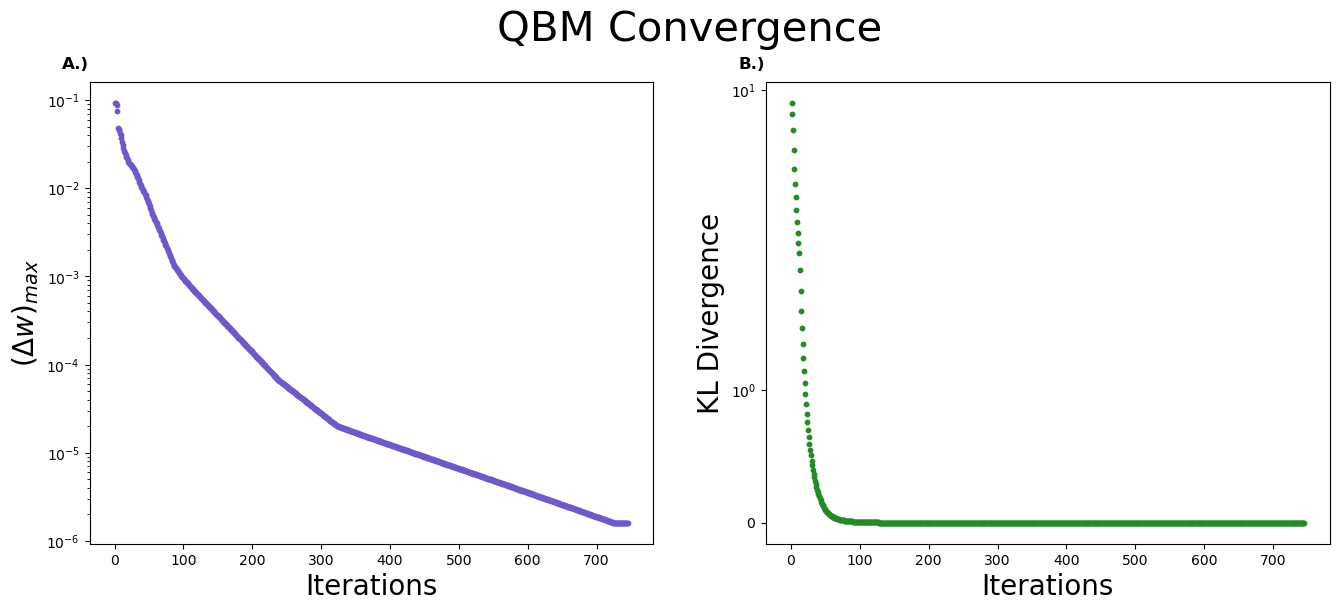

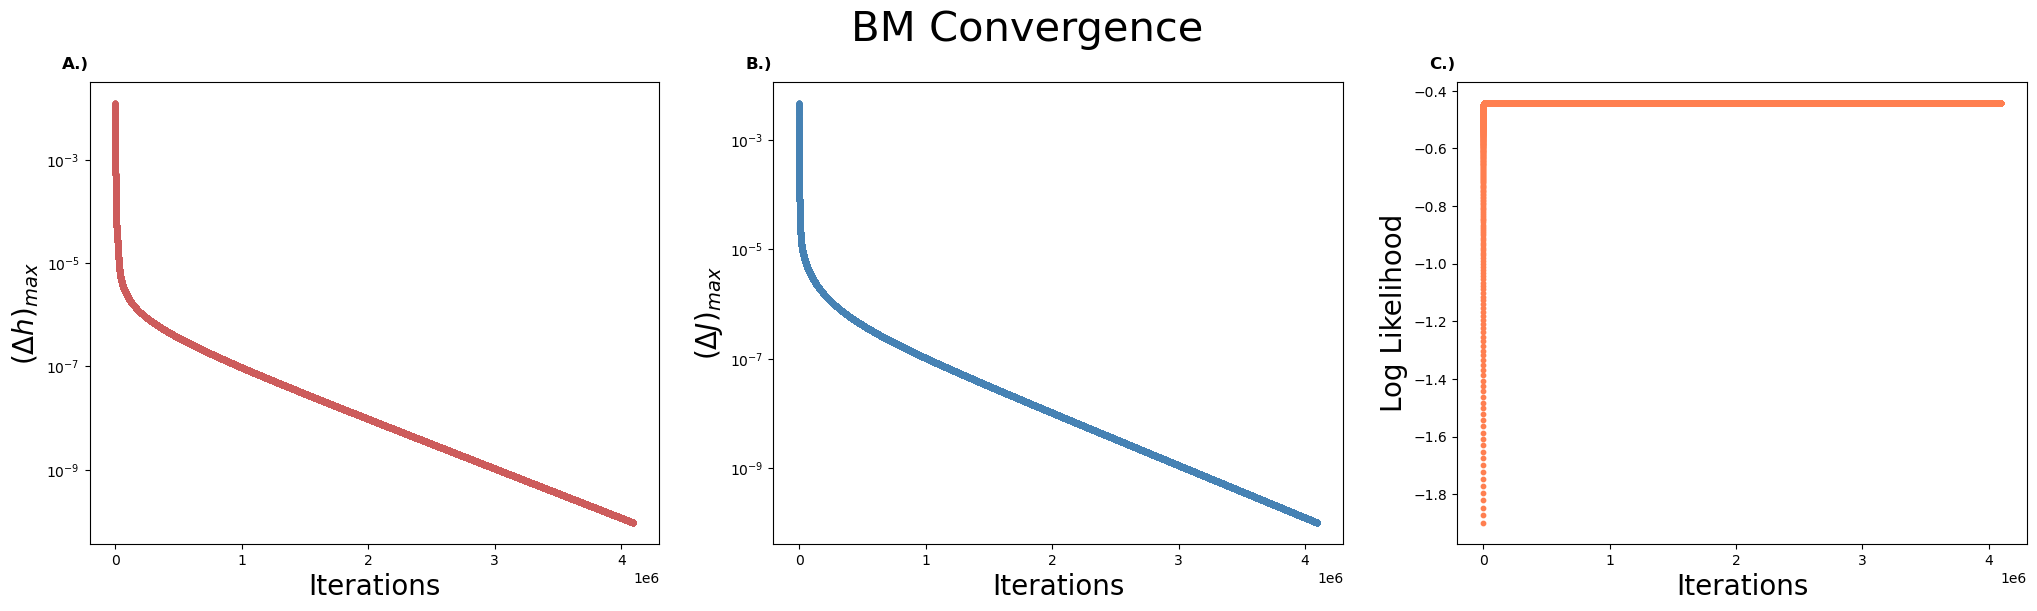

In [44]:
dont_run = 1  #skip this due to long computation time
if dont_run == 1: 

    # initialize the classical parameters
    N = 4
    w = np.array([[5.20,5.24,5.26,5.17],
                  [5.24,5.26,5.20,5.19],
                  [5.26,5.20,5.22,5.20],
                  [5.17,5.19,5.20,5.20]], dtype=np.float64)
    
    J = np.array([[0,.1,.2,.3],
                  [.1,0,.1,.3],
                  [.2,.1,0,.2],
                  [.3,.3,.2,0]],      dtype=np.float64)
    
    h = np.array([1, 2, 1, 2],        dtype=np.float64)

    check_parameters(w,J,h)

    #intialize the optimal learning parameters for 4-qubits
    learning_rate_qbm = .1
    maxiter_qbm = 2**11

    learning_rate_bm = .004
    maxiter_bm = 2**22

    # map forward and back. Set plot_convergence to True if you want to see the convergence plots
    w_qm = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = True, perform_checks = False)
    w_recovered, J_recovered, h_recovered = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = True, perform_checks = False)

    print('Difference in initial and recovered parameters:')
    print(f'w: \n {np.abs(w - w_recovered)}')
    print(f'J: \n {np.abs(J - J_recovered)}')
    print(f'h: \n {np.abs(h - h_recovered)}')

## Forward Mapping

We have to make sure that for all values of the parameter sweep, we don't need to use min_w. Probably write another function for that sometime

### Results 2-qubits

#### Varying J in Homogenous system with biases and self-interactions

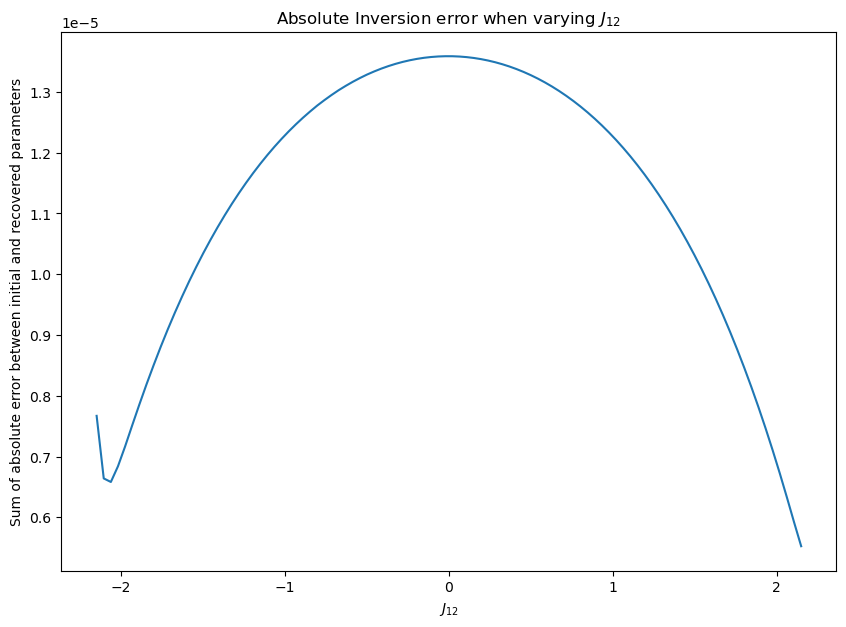

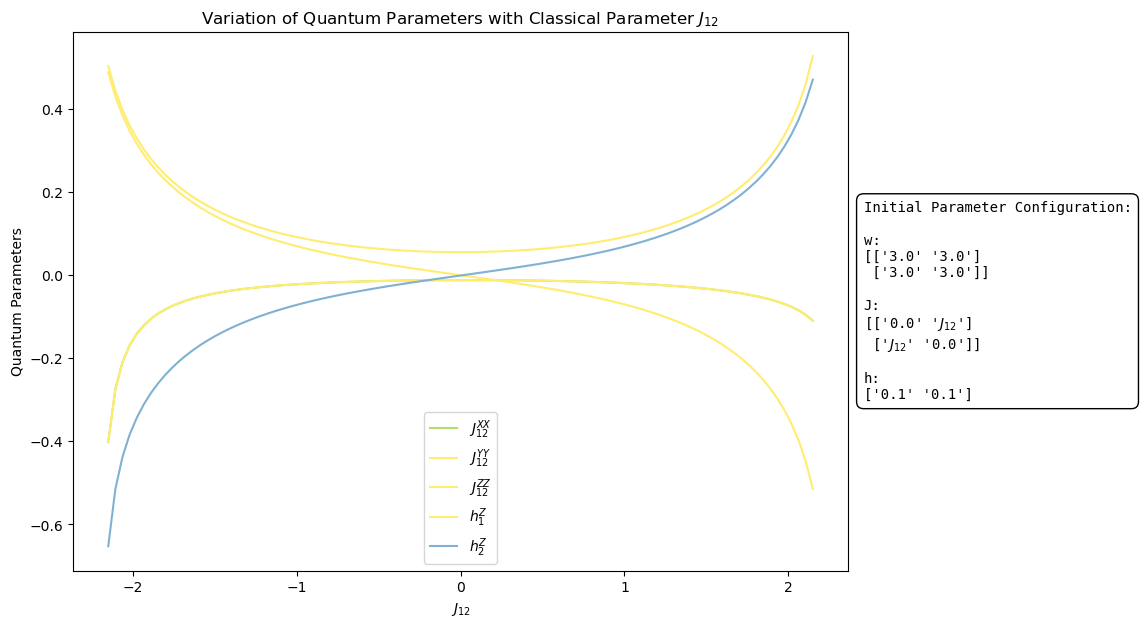

In [61]:
# initialize the classical parameters
N = 2
w = np.array([[3, 3], 
              [3, 3]],   dtype=np.float64)
J = np.array([[0, 1],
              [1, 0]],   dtype=np.float64)
h = np.array([.1, .1],   dtype=np.float64)

# define the classical parameter that will be varied
param = 'J'
index = (0, 1)

# define the range over which the classical parameter will be varied
start = -2.15
end = 2.15
steps = 100

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**22

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

#optional: check the inversion error to see if trajectory is valid:
parameter_sweep_error(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# plot_params = [ 'J^{XZ}_{14}', 'h^{Y}_{2}', ''sigma^{YXZ}_{123}] #should work somehthing like this
threshold = 0.1  #minimal change over sweep for the parameters to be plotted

# call the function
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

plot_forward_mapping(quantum_params, start, end, steps, param, index, w, J, h, N, qm_params_to_plot, threshold, print_initial_config = True)


#### Varying J in Homogenous system with self-interactions but no biases

In [ ]:
# initialize the parameters
N = 2
w = np.array([[3, 3], 
              [3, 3]], dtype=np.float64)
J = np.array([[0, 1],
              [1, 0]],   dtype=np.float64)
h = np.array([.00000000000001, .00000000000001],    dtype=np.float64)

check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'J'
index = (0, 1)

# define the range over which the classical parameter will be varied
start = -2.15
end = 2.15
steps = 100

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**11

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = None
# plot_params = [ 'J^{XZ}_{14}', 'h^{Y}_{2}', ''sigma^{YXZ}_{123}] #should work somehthing like this

# specify the change threshold
threshold = 0.1

# call the function
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

plot_forward_mapping(quantum_params, start, end, steps, param, index, N, qm_params_to_plot, threshold)


### Results 3-qubit

#### Varying J in Homogenous system with biases and self-interactions

In [ ]:
# initialize the parameters
N = 3
w = np.array([[3, 3 ,3],
              [3, 3, 3],
              [3, 3, 3]], dtype = np.float64)

J = np.array([[0, 0, 0],
              [0 ,0, 0],
              [0, 0, 0]], dtype = np.float64)

h = np.array([.1, .1, .1],   dtype = np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'J'
index = (0, 1)

# define the range over which the classical parameter will be varied
start = -.7
end = .7
steps = 30

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**11

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = ['$J_{12}^{ZZ}$', '$J_{12}^{YY}$'] 


# specify the change threshold
threshold = 0.00001

# call the function
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

plot_forward_mapping(quantum_params, start, end, steps, param, index, N, qm_params_to_plot, threshold)

Smaller biases

In [ ]:
# initialize the parameters
N = 3
w = np.array([[3, 3 ,3],
              [3, 3, 3],
              [3, 3, 3]], dtype = np.float64)

J = np.array([[0, 0, 0],
              [0 ,0, 0],
              [0, 0, 0]], dtype = np.float64)

h = np.array([.000001, .000001, .000001],   dtype = np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'J'
index = (1, 2)

# define the range over which the classical parameter will be varied
start = -.7
end = .7
steps = 30

# intialize the optimal learning parameters for 2-qubits
learning_rate_qbm = .5
maxiter_qbm = 2**11

#only relevant for checking if the mapping is inverisble
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = ['$J_{12}^{ZZ}$', '$J_{12}^{YY}$'] 

# specify the change threshold
threshold = 0.00001

# call the function
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

plot_forward_mapping(quantum_params, start, end, steps, param, index, N, qm_params_to_plot, threshold)

### Same shit, larger biases

In [ ]:
# initialize the parameters
N = 3
w = np.array([[3, 3 ,3],
              [3, 3, 3],
              [3, 3, 3]], dtype = np.float64)

J = np.array([[0, 0, 0],
              [0 ,0, 0],
              [0, 0, 0]], dtype = np.float64)

h = np.array([.75, .75, .75],   dtype = np.float64)

#check if we got valid parameters
check_parameters(w, J, h)

# define the classical parameter that will be varied
param = 'J'
index = (0, 1)

# define the range over which the classical parameter will be varied
start = 0
end = .70
steps = 30

learning_rate_qbm = .5
maxiter_qbm = 2**20

#only relevant for checking if the mapping is inversible
learning_rate_bm = .8
maxiter_bm = 2**20

# specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
qm_params_to_plot = ['$J_{12}^{ZZ}$', '$J_{12}^{YY}$'] 

# specify the change threshold
threshold = 0.01

# call the function
quantum_params = analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm)

plot_forward_mapping(quantum_params, start, end, steps, param, index, N, qm_params_to_plot, threshold)

### Results 4-qubit

Expect 30-40 min for convergence of QBM. Try agressive learning rates first

In [ ]:
dont_run = 1  #skip this due to long computation time
if dont_run == 0: 

    # initialize the classical parameters
    w = np.array([[4.,2.,4.,5.],
                [2.,4.,1.,3.],
                [4.,1.,2.,4.],
                [5.,3.,4.,5.]])
    J = np.array([[0,1,2,3],
                [1,0,1,3],
                [2,1,0,2],
                [3,3,2,0]])
    h = np.array([1, 2, 3, 4])

    check_parameters(w,J,h)

    # define the start, end and step size for the parameter change
    start = -10
    end = 10
    steps = 30

    # define the parameter and index you want to change
    param = 'J'
    index = (0, 1)

    # intialize the optimal learning parameters for 3-qubits
    learning_rate_qbm = .9
    maxiter_qbm = 2**15

    learning_rate_bm = .9
    maxiter_bm = 2**20

    # specify the quantum parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
    plot_params = None
    # plot_params = ['w_0_1', 'J_0_1', 'h_0']

    # specify the change threshold
    threshold = 0.01

    # call the function
    analyze_forward_parameter_mapping(start, end, steps, param, index, w, J, h, learning_rate_qbm, maxiter_qbm, learning_rate_bm, maxiter_bm, plot_params, threshold)


## Inverse Mapping

In [ ]:
#plot the dynamics
N = 2
steps = 200
W = compute_transition_matrix(w, h, J)
trajectory = simulate_dynamics(W, steps, N)
plot_combined_dynamics(trajectory, N)

### Inverse mapping reversibility

- Check what happens when you use 3rd body interactions in the QM hamiltonian

#### When QM parameters map to a dynamics that does not satisfy detailed balance

In [ ]:
N = 2

#initialize the quantum paramters
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I')] =  0

#hx1 > Jxz
interaction_weights[('I', 'X')] = .8   #hx1
interaction_weights[('X', 'Z')] = .5   #Jxz

#hx2 > Jzx
interaction_weights[('X', 'I')] = .6   #hx2
interaction_weights[('Z', 'X')] = .4   #Jzx

# Jxx > Jyy
interaction_weights[('X', 'X')] = .8   #Jxx
interaction_weights[('Y', 'Y')] = .2   #Jyy

# all Z-only terms < 1
interaction_weights[('I', 'Z')] = .1   #hz1
interaction_weights[('Z', 'I')] = .1   #hz2
interaction_weights[('Z', 'Z')] = .4   #Jzz

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)

#generate a rho and its associated W
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

rho = rho_model(w_qm,interaction_matrices)
check_density_matrix(rho)

W = density_matrix_to_transition_matrix(rho)
test_transition_matrix(W)
check_detailed_balance(W)

#infer the classical parameters using a classical boltzmann machine
w, J, h = infer_parameters(W, maxiter = 2**14, learning_rate = .2, plot = True)

W_return = compute_transition_matrix(w, h, J)

print(f'Initial qm parameters: {w_qm}')
print(f'Density matrix: \n {rho_model(w_qm,interaction_matrices)}')
print(f'Transition matrix: \n {W}')
print(f'Returned transition matrix \n {W_return}')

In [ ]:
W = np.array( [[0.49, 0.21, 0.22, 0.08],
               [0.46, 0.24, 0.23, 0.07],
               [0.46, 0.22, 0.24, 0.08],
               [0.44, 0.18, 0.21, 0.17]])

check_detailed_balance(W)

# W_sym = W + 

#check validity of W
check_detailed_balance(W)
test_transition_matrix(W)

w, J, h = infer_parameters(W)

print(w)
print(J)
print(h)

W_return = compute_transition_matrix(w, h, J)
print(W_return)
check_parameters(w,J,h)


In [ ]:
#intialize the learning parameters
learning_rate_qbm = .9
maxiter_qbm = 2**14

learning_rate_bm = .9
maxiter_bm = 2**18


w, J, h = inverse_mapping(w_qm, learning_rate_bm, maxiter_bm, plot_convergence = True)

print('Rho maps to classical parameters:')
print(f' w: \n {w}')
print(f' J: \n {J}')
print(f' h: \n {h}')

w_qm_recovered = forward_mapping(w, J, h, learning_rate_qbm, maxiter_qbm, plot_convergence = True)

print(f'Difference in initial and recovered parameters: \n {np.abs(w_qm - w_qm_recovered)}')

Splitting W into a symmetric and assymetric part. Maybe we can split into a symmetric part and assymetric part and individually see to which QM parameters these transition matrices map back. In the symmetric case, we can also map it forward to classical parameters.

#### check if symmetry of the xz zx terms leads to detailed balance


In [ ]:
#generate the weights using the dictionary
num_qubits = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I')] =  0

#hx1 > Jxz
interaction_weights[('I', 'X')] = .8   #hx1
interaction_weights[('X', 'Z')] = .5   #Jxz

#hx2 > Jzx
interaction_weights[('X', 'I')] = .6   #hx2
interaction_weights[('Z', 'X')] = .4   #Jzx

# Jxx > Jyy
interaction_weights[('X', 'X')] = .6   #Jxx
interaction_weights[('Y', 'Y')] = .2   #Jyy

# all Z-only terms < 1
interaction_weights[('I', 'Z')] = .1   #hz1
interaction_weights[('Z', 'I')] = .1   #hz2
interaction_weights[('Z', 'Z')] = .4   #Jzz

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)


#qm hamiltonian to density matrix
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 
rho = rho_model(w_qm, interaction_matrices)

print('Input QM parameters')
for k, v in interaction_weights.items():
    print (k, ':', v)
print(f' Associated density matrix: \n {np.real(rho)}')
print(f' Associated eigenvalues of rho {np.real(np.linalg.eigvals(rho))}')
#density matrix to transition matrix
W = density_matrix_to_transition_matrix(rho)


### 2-Qubits Result

#### Influence of Jxx term

In [ ]:
# initialize the qm parameters using the weight dictionary
N = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)
#set everything to zero
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

# define the quantum parameter that will be varied
quantum_param_label = ('X','X')

# define the range over which the classical parameter will be varied
start = -2
end = 2
steps = 50

# intialize the optimal learning parameters for 2-qubits
learning_rate_bm = .9
maxiter_bm = 2**19

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None
# plot_params = ['w_{12}', 'J_{14}', 'h_{2}'] #should work somehthing like this

# specify the change threshold
threshold = 0.01

# call the function
analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_bm,  maxiter_bm, classical_params_to_plot = None, threshold=0.01)

#### Influence of Jyy term

In [ ]:
# initialize the qm parameters using the weight dictionary
N = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)
#set everything to zero
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

# define the quantum parameter that will be varied
quantum_param_label = ('Y','Y')

# define the range over which the classical parameter will be varied
start = -2
end = 2
steps = 50
# intialize the optimal learning parameters for 2-qubits
learning_rate_bm = .9
maxiter_bm = 2**19

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None

# specify the change threshold
threshold = 0.01

# call the function
analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_bm,  maxiter_bm, classical_params_to_plot = None, threshold=0.01)

#### Influence of Jzz term

In [ ]:
# initialize the qm parameters using the weight dictionary
N = 2
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(N)
#set everything to zero
w_qm = weights_dict_to_array(interaction_labels, interaction_weights) 

# define the quantum parameter that will be varied
quantum_param_label = ('Z','Z')

# define the range over which the classical parameter will be varied
start = -2
end = 2
steps = 50

# intialize the optimal learning parameters for 2-qubits
learning_rate_bm = .9
maxiter_bm = 2**19

# specify the classical parameters to plot, if you select none, all that change more than the threshold over the sweep will be plotted
classical_params_to_plot = None

# specify the change threshold
threshold = 0.01

# call the function
analyze_inverse_parameter_mapping(start, end, steps, quantum_param_label, w_qm, learning_rate_bm,  maxiter_bm, classical_params_to_plot = None, threshold=0.01)

### 3 Qubits

In [ ]:
num_qubits = 3
interaction_matrices,interaction_labels,interaction_weights = generate_interaction_matrices(num_qubits)

#Leave out the terms containing odd amounts of Y
interaction_weights[('I', 'I', 'I')] = 0    #log(Z)

#hxi > Jxzij + jxzik
interaction_weights[('X', 'I', 'I')] = .5   #hx1
interaction_weights[('X', 'Z', 'I')] = .1   #Jxz12
interaction_weights[('X', 'I', 'Z')] = .2   #Jxz13

interaction_weights[('I', 'X', 'I')] = .4   #hx2
interaction_weights[('I', 'X', 'Z')] = .1   #Jxz23
interaction_weights[('Z', 'X', 'I')] = .1   #Jzx12

interaction_weights[('I', 'I', 'X')] = .8   #hx3
interaction_weights[('I', 'Z', 'X')] = .2   #Jzx23
interaction_weights[('Z', 'I', 'X')] = .3   #Jzx13


# Jxx > Jyy
interaction_weights[('X', 'X', 'I')] = .6   #Jxx12
interaction_weights[('Y', 'Y', 'I')] = .4   #Jyy12

interaction_weights[('I', 'X', 'X')] = .7   #Jxx23
interaction_weights[('I', 'Y', 'Y')] = .4   #Jyy23

interaction_weights[('X', 'I', 'X')] = .8   #Jxx13
interaction_weights[('Y', 'I', 'Y')] = .4   #Jyy13


# all Z-only terms < 1
interaction_weights[('Z', 'I', 'I')] = .1   #hz1
interaction_weights[('I', 'Z', 'I')] = .1   #hz2
interaction_weights[('I', 'I', 'Z')] = .1   #hz3

interaction_weights[('Z', 'Z', 'I')] = .3   #Jzz12
interaction_weights[('Z', 'I', 'Z')] = .3   #Jzz13
interaction_weights[('I', 'Z', 'Z')] = .3   #Jzz23

# make sure there are no imaginary components
interaction_weights = set_odd_y_interactions_to_zero(interaction_labels, interaction_weights)